# Definition

## Project Overview

* Project Origin: [Kaggle - Facebook V: Predicting Check Ins](https://www.kaggle.com/c/facebook-v-predicting-check-ins)
* Description: Facebook and Kaggle launched a machine learning engineering competition of identifying the correct place for check ins. For giving a flavor of what it takes to work with real data, Facebook created an artificial world consisting of more than 100,000 places located in a 10 km by 10 km square and data was fabricated to resemble location signals coming from mobile devices.
* Data sets:
    * train.csv, test.csv
        * row_id: id of the check-in event
        * x y: coordinates
        * accuracy: location accuracy 
        * time: timestamp
        * place_id: id of the business (this is the target I'm  predicting)

## Problem Statement

* Definition:
    * Predicting the top 3 places a person would most likely to check in to.
    * Total number of places on the map is over 100000.
    * The probability of place could be modeled as $$Pr(place\_id\ |\ x, y, time, acccuracy)$$
    * This problem is categorized as supervised classification.
* Proposed Solution:
    1. K-Nearest Neighbors
        * Since I do not have any assumptions about the data distribution, KNN could be the good start point.
        * The weight of coordinates should be much higher than others.
    2. Gaussian Naive Bayes
        * When looking at histograms of features, we could see that all the shape look like a bell. So I think it's worth trying to know how well this method could achieve.
    3. Kernel Density Estimation
        * Based on the result of GNB, the assumption that all conditional probabilities of features were independent may hold on this problem
        * KDE could help finding more accurate estimation of probabilities of features
    4. Ensemble
        * At final step, I try to ensemble above three models with customized method.
        * This method is inspired by [Larry Freeman](https://github.com/larry94555/kaggle-Facebook-V)

## Metrics

* Prediction is evaluated according to the [Mean Average Precision @3](https://www.kaggle.com/wiki/MeanAveragePrecision)
    $$MAP@3 = \frac{1}{|U|} \sum_{u=1}^{|U|} \sum_{k=1}^{min(3,n)} P(k)$$
    * |U| is the number of check in events
    * P(k) is the precision at cutoff k
    * n is the number of predicted businesses.

# Analysis

## Data Exploration
* In this section, I try to explore values distribution of following features:
    * Coordinates
    * Accuracy
    * Place_ids

In [1]:
import math
import os
import pandas as pd
import numpy as np
import time
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# For checking progress
from tqdm import tqdm_notebook, tnrange

# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D scatter
import matplotlib.cm as cm # For colored labels
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16

In [2]:
# Reading data
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
# Count the occurrences of place_id
place_ranking = df_train.place_id.value_counts()

In [4]:
# Basic statistics of data
print 'Size of training data: {}'.format(df_train.shape)
print 'Size of testing data: {}'.format(df_test.shape)

Size of training data: (29118021, 6)
Size of testing data: (8607230, 5)


In [5]:
print "Description of training data: \n"
print df_train.describe()

Description of training data: 

             row_id             x             y      accuracy          time  \
count  2.911802e+07  2.911802e+07  2.911802e+07  2.911802e+07  2.911802e+07   
mean   1.455901e+07  4.999770e+00  5.001814e+00  8.284912e+01  4.170104e+05   
std    8.405649e+06  2.857601e+00  2.887505e+00  1.147518e+02  2.311761e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
25%    7.279505e+06  2.534700e+00  2.496700e+00  2.700000e+01  2.030570e+05   
50%    1.455901e+07  5.009100e+00  4.988300e+00  6.200000e+01  4.339220e+05   
75%    2.183852e+07  7.461400e+00  7.510300e+00  7.500000e+01  6.204910e+05   
max    2.911802e+07  1.000000e+01  1.000000e+01  1.033000e+03  7.862390e+05   

           place_id  
count  2.911802e+07  
mean   5.493787e+09  
std    2.611088e+09  
min    1.000016e+09  
25%    3.222911e+09  
50%    5.518573e+09  
75%    7.764307e+09  
max    9.999932e+09  


* We can see that testing and training data are splitted by time.
    * Training: Range of time is [1, 786239]
    * Testing: Range of time is [786242, 1006589]

In [6]:
print "Description of testing data: \n"
print df_test.describe()
del df_test

Description of testing data: 

             row_id             x             y      accuracy          time
count  8.607230e+06  8.607230e+06  8.607230e+06  8.607230e+06  8.607230e+06
mean   4.303614e+06  4.991417e+00  5.006705e+00  9.265208e+01  8.904637e+05
std    2.484693e+06  2.866409e+00  2.886888e+00  1.242906e+02  6.446783e+04
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  7.862420e+05
25%    2.151807e+06  2.517000e+00  2.502400e+00  4.200000e+01  8.332200e+05
50%    4.303614e+06  4.988000e+00  5.000900e+00  6.400000e+01  8.874620e+05
75%    6.455422e+06  7.463600e+00  7.505300e+00  7.900000e+01  9.454910e+05
max    8.607229e+06  1.000000e+01  1.000000e+01  1.026000e+03  1.006589e+06


### Coordinate
* We can see that the **check-ins are roughly uniformly distributed on the map**.
* Because the number of data is huge, only taking 1% random samples to investigate the distribution of x and y. 

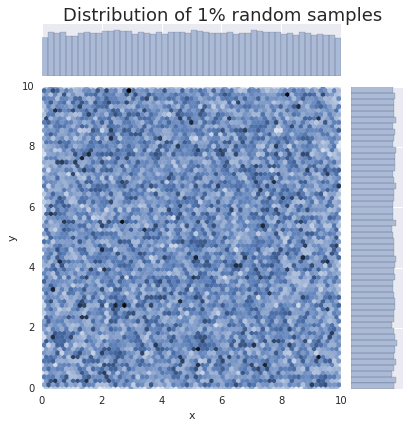

In [7]:
sns.jointplot(data=df_train.sample(frac=0.01), x='x',y='y',kind='hex', stat_func=None,
             xlim=(0,10),ylim=(0,10));
plt.title('Distribution of 1% random samples',x=-2.5,y=1.2,fontsize=18);

* From the top 3 popular places, we can know that **standard deviation of x is much more than y.**

Standard deviation of x: 0.356139513132
Standard deviation of y: 0.0115436699085


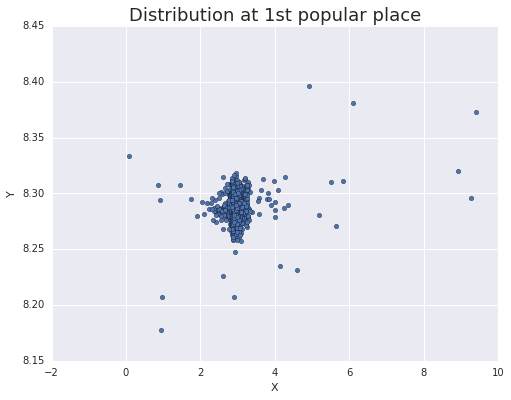

In [8]:
data = df_train[df_train.place_id==place_ranking.index[0]]
data.plot(kind='scatter', x='x', y='y')
plt.title('Distribution at 1st popular place',fontsize=18)
plt.xlabel('X')
plt.ylabel('Y')
print 'Standard deviation of x: {}'.format(data.x.std())
print 'Standard deviation of y: {}'.format(data.y.std())
del data

Standard deviation of x: 0.240642261874
Standard deviation of y: 0.0157120481921


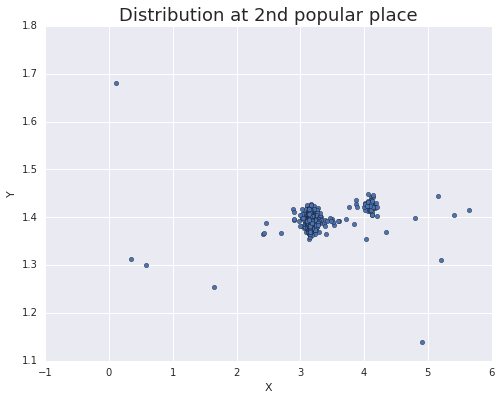

In [9]:
data = df_train[df_train.place_id==place_ranking.index[1]]
data.plot(kind='scatter', x='x', y='y')
plt.title('Distribution at 2nd popular place',fontsize=18)
plt.xlabel('X')
plt.ylabel('Y')
print 'Standard deviation of x: {}'.format(data.x.std())
print 'Standard deviation of y: {}'.format(data.y.std())
del data

Standard deviation of x: 0.340146567801
Standard deviation of y: 0.0176619907468


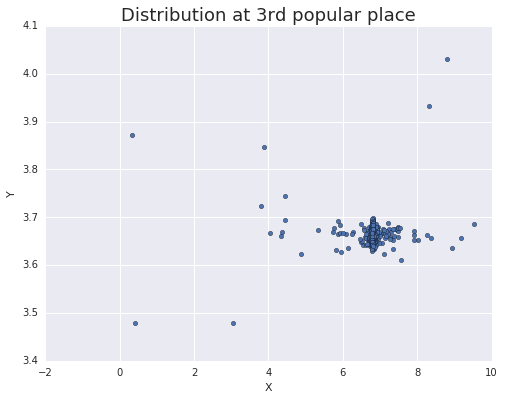

In [10]:
data = df_train[df_train.place_id==place_ranking.index[2]]
data.plot(kind='scatter', x='x', y='y')
plt.title('Distribution at 3rd popular place',fontsize=18)
plt.xlabel('X')
plt.ylabel('Y')
print 'Standard deviation of x: {}'.format(data.x.std())
print 'Standard deviation of y: {}'.format(data.y.std())
del data

### Accuracy
* From the histogram of accuracy, **we could know that majority of value is under 200**.
* The meaning of accuracy is still vague.

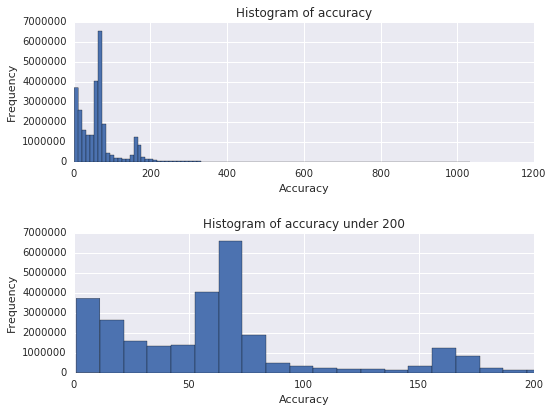

In [11]:
_, AX = plt.subplots(nrows=2, sharey=True)
AX[0].set_title('Histogram of accuracy')
AX[0].set_xlabel('Accuracy')
AX[0].set_ylabel('Frequency')
df_train['accuracy'].hist(bins=100,ax=AX[0])
AX[1].set_title('Histogram of accuracy under 200')
AX[1].set_xlim((0,200))
AX[1].set_xlabel('Accuracy')
AX[1].set_ylabel('Frequency')
df_train.accuracy.hist(bins=100,ax=AX[1])
plt.tight_layout(h_pad=1.5)

### Place Ids
* From this section, we can know that **there are a huge number of place ids and they are not uniformly distributed.** This means that any algorithm which trains using a one vs all approach would not be the best choice on this dataset.
* What is "one vs all approach"?
    * This approach is training a single classifier per class for solving multiclass problems of n classes with the samples of that class as positive samples and all other samples as negatives.
    * Reference
        * [Wiki](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)
        * [Multiclass Classification by Ryan Rifkin](http://www.mit.edu/~9.520/spring09/Classes/multiclass.pdf)

In [12]:
unique_id = df_train.place_id.unique()
print "Number of unique place id: {}, roughly {:.3f} % of traing data.".format(len(unique_id), 
                                                                               len(unique_id) * 100.0 / df_train.shape[0])
del unique_id

Number of unique place id: 108390, roughly 0.372 % of traing data.


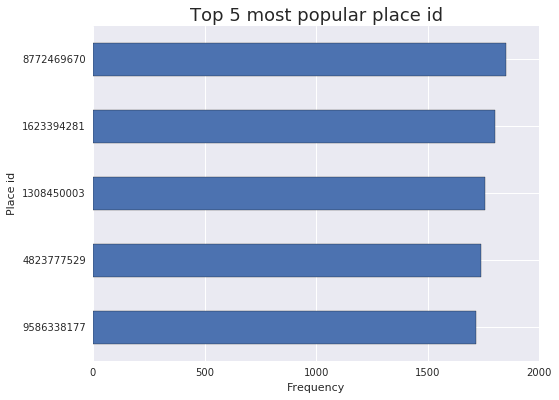

In [13]:
plt.xlabel('Frequency')
plt.ylabel('Place id')
place_ranking.head(5).plot.barh(xlim=(0,2000)).invert_yaxis()
plt.title('Top 5 most popular place id', fontsize=18);

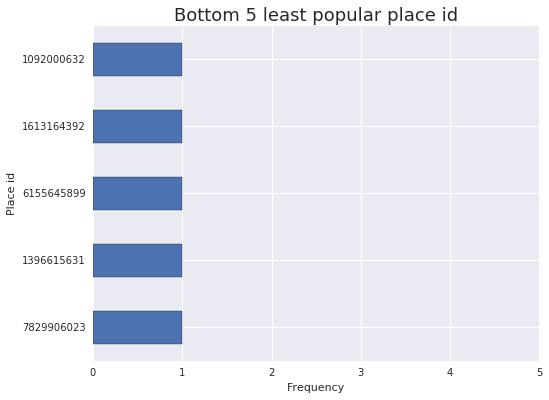

In [14]:
plt.xlabel('Frequency')
plt.ylabel('Place id')
place_ranking.tail(5).plot.barh(xlim=(0,5))
plt.title('Bottom 5 least popular place id', fontsize=18);

## Exploratory Visualization
* In this section, I try to focus representing following things:
    * Explain why the unit of time would be minute.
    * Explain why I use log function to convert accuracy.
    * Explain why feature of time would be one of the most important features.

### Explore Time

* Because the column of time is intentionally left vague without defining the unit of time, **this section provides two methods to conclude the unit of time would be minute.**
* Method 1: Converted the time to weekdays in order to visualize the weekly cycle at the top 3 popular places. [(Reference)](https://www.kaggle.com/jsab16/facebook-v-predicting-check-ins/on-time/comments)

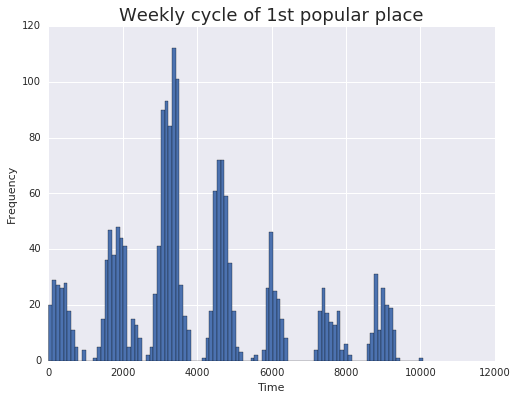

In [15]:
# 1st popular place : 8772469670
time = df_train[df_train.place_id==place_ranking.index[0]].time
time = time % (24*60*7) # Converted into weekdays
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Weekly cycle of 1st popular place', fontsize=18)
time.hist(bins=100);

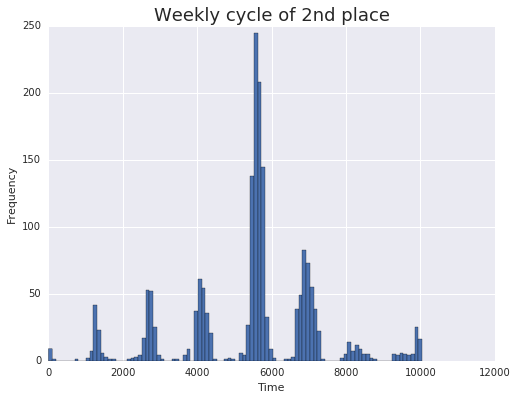

In [16]:
# 2nd popular place : 1623394281
time = df_train[df_train.place_id==place_ranking.index[1]].time
time = time % (24*60*7) # Converted into weekdays
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Weekly cycle of 2nd place', fontsize=18)
time.hist(bins=100);

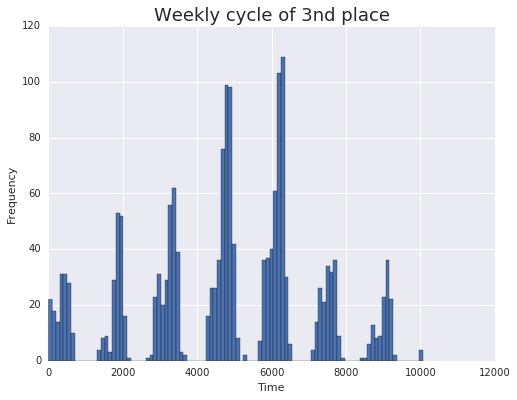

In [17]:
# 3rd popular place : 1308450003
time = df_train[df_train.place_id==place_ranking.index[2]].time
time = time % (24*60*7) # Converted into weekdays
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Weekly cycle of 3nd place', fontsize=18)
time.hist(bins=100);

* Method 2: Used Fourier transform to extract the dominant frequency in order to find the period at the top 3 place. [(Reference)](https://www.kaggle.com/leonlu/facebook-v-predicting-check-ins/another-way-to-know-the-time-definition/comments)

Period 1: 10151.96875, close to 10080 minutes a week.
Period 2: 1440.63414634, close to 1440 minutes a day.


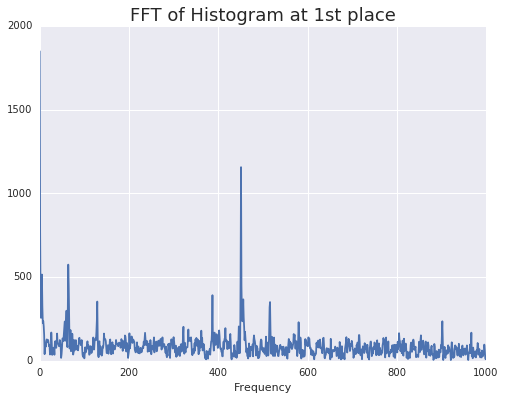

In [18]:
# 1st popular place : 8772469670
time = df_train[df_train.place_id==place_ranking.index[0]].time
# Histogram of time
hist = np.histogram(time,5000)
# FFT of Histogram
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of Histogram at 1st place', fontsize=18)
plt.xlabel('Frequency')

print "Period 1: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "Period 2: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[400:600].argmax()+400.0))

Period 1: 10200.4155844, close to 10080 minutes a week.
Period 2: 1449.13653137, close to 1440 minutes a day.


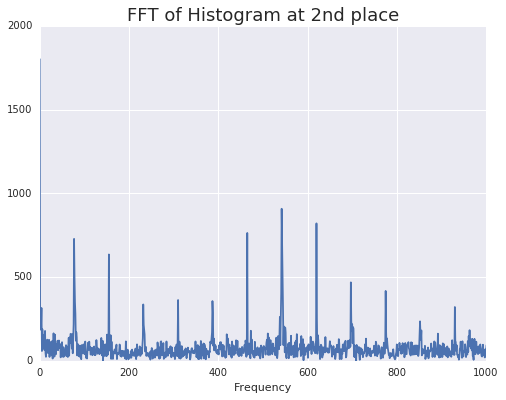

In [19]:
# 2nd popular place : 1623394281
time = df_train[df_train.place_id==place_ranking.index[1]].time
# Histogram of time
hist = np.histogram(time,5000)
# FFT of Histogram
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of Histogram at 2nd place', fontsize=18)
plt.xlabel('Frequency')

print "Period 1: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "Period 2: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[400:600].argmax()+400.0))

Period 1: 10138.9482759, close to 10080 minutes a week.
Period 2: 1451.99753086, close to 1440 minutes a day.


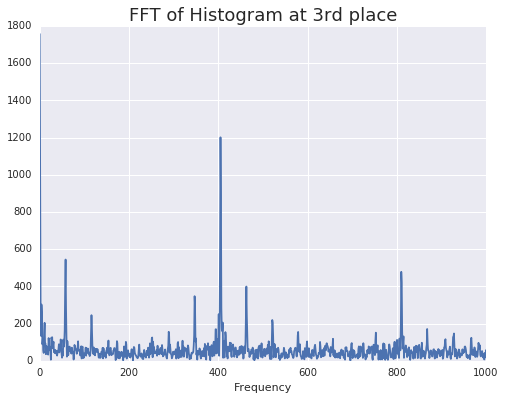

In [20]:
# 3rd popular place : 1308450003
time = df_train[df_train.place_id==place_ranking.index[2]].time
# Histogram of time
hist = np.histogram(time,5000)
# FFT of Histogram
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of Histogram at 3rd place', fontsize=18)
plt.xlabel('Frequency')

print "Period 1: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "Period 2: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[300:500].argmax()+300.0))

del time

* Suppose the unit of time is minute, we can calculate the time period of collecting data.
* It took roughly one and half year.

In [21]:
T = df_train.time.max() - df_train.time.min()
T = pd.Timedelta(minutes=T)
print "Time period of collecting data is {} days {} hours {} minutes".format(T.days, T.seconds/3600, T.seconds/60%60)
del T

Time period of collecting data is 545 days 23 hours 58 minutes


* From the below histograms at top 2 popular places, we could see that the check-ins are highly related with hours, weekday, and months. Maybe the reason is places have their own opening and closed time schedules.
* The top 2 popular places looks complementary on opening hours.

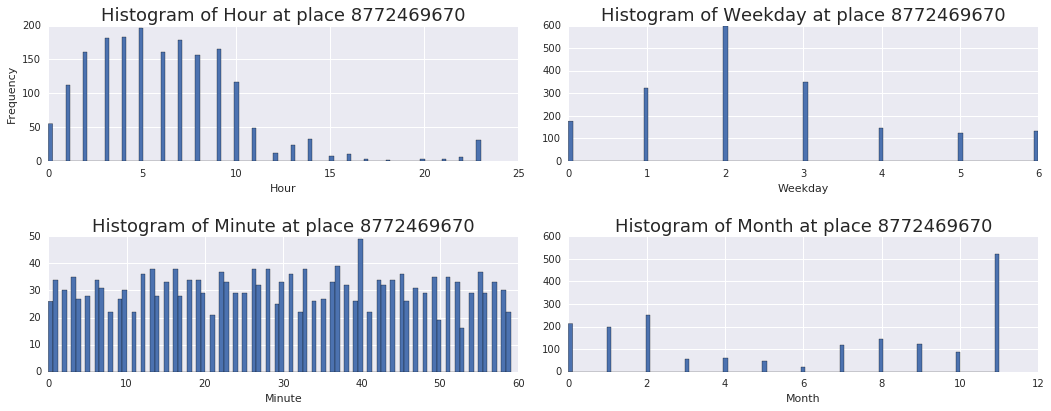

In [22]:
# Histogram of hour and minute at the 1st popular place
place = place_ranking.index[0]
_, AX = plt.subplots(ncols=2, nrows=2, figsize=(15,6))
data = df_train[df_train.place_id==place]
data.hour = ((data.time/60)%24).astype(int)
data.hour.hist(bins=100,ax=AX[0][0])
AX[0][0].set_title('Histogram of Hour at place {}'.format(place), fontsize=18)
AX[0][0].set_xlabel('Hour')
AX[0][0].set_ylabel('Frequency')

data.weekday = ((data.time/(60*24))%7).astype(int)
data.weekday.hist(bins=100,ax=AX[0][1])
AX[0][1].set_title('Histogram of Weekday at place {}'.format(place), fontsize=18)
AX[0][1].set_xlabel('Weekday')

data.minute = (data.time%60).astype(int)
data.minute.hist(bins=100,ax=AX[1][0])
AX[1][0].set_title('Histogram of Minute at place {}'.format(place), fontsize=18)
AX[1][0].set_xlabel('Minute')

data.month = (data.time/(60*24*30)%12).astype(int)
data.month.hist(bins=100,ax=AX[1][1])
AX[1][1].set_title('Histogram of Month at place {}'.format(place), fontsize=18)
AX[1][1].set_xlabel('Month')

plt.tight_layout(h_pad=1.5)

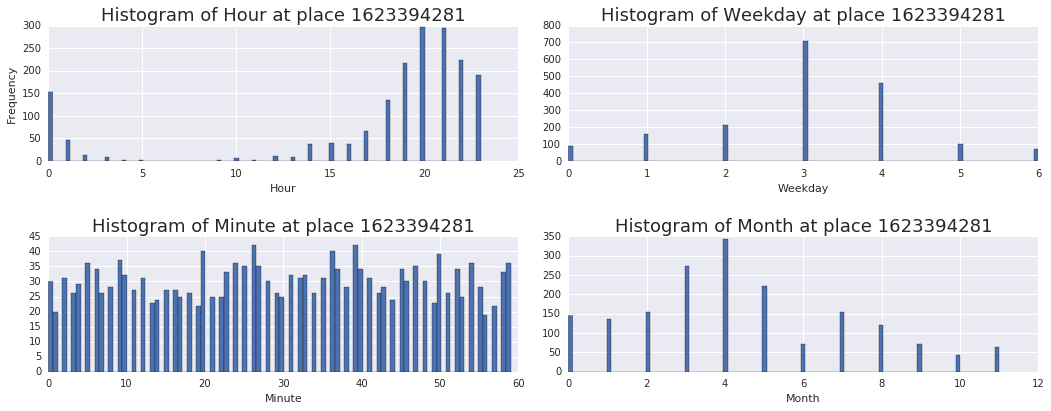

In [23]:
# Histogram of hour and minute at the 2nd popular place
place = place_ranking.index[1]
_, AX = plt.subplots(ncols=2, nrows=2, figsize=(15,6))
data = df_train[df_train.place_id==place]
data.hour = ((data.time/60)%24).astype(int)
data.hour.hist(bins=100,ax=AX[0][0])
AX[0][0].set_title('Histogram of Hour at place {}'.format(place), fontsize=18)
AX[0][0].set_xlabel('Hour')
AX[0][0].set_ylabel('Frequency')

data.weekday = ((data.time/(60*24))%7).astype(int)
data.weekday.hist(bins=100,ax=AX[0][1])
AX[0][1].set_title('Histogram of Weekday at place {}'.format(place), fontsize=18)
AX[0][1].set_xlabel('Weekday')

data.minute = (data.time%60).astype(int)
data.minute.hist(bins=100,ax=AX[1][0])
AX[1][0].set_title('Histogram of Minute at place {}'.format(place), fontsize=18)
AX[1][0].set_xlabel('Minute')

data.month = (data.time/(60*24*30)%12).astype(int)
data.month.hist(bins=100,ax=AX[1][1])
AX[1][1].set_title('Histogram of Month at place {}'.format(place), fontsize=18)
AX[1][1].set_xlabel('Month')

plt.tight_layout(h_pad=1.5)

del data,place

### Explore accuracy
* [CV](http://www.insee.fr/en/methodes/default.asp?page=definitions/coefficient-de-variation.htm): coefficient of variation, which is the ratio of the standard deviation to the mean. The higher the coefficient of variation, the greater the level of dispersion around the mean.
* From below two scores of CV, we can see that the log of accuracy the level of dispersion is less.

CV of accuracy: 1.385
CV of log of accuracy: 0.292


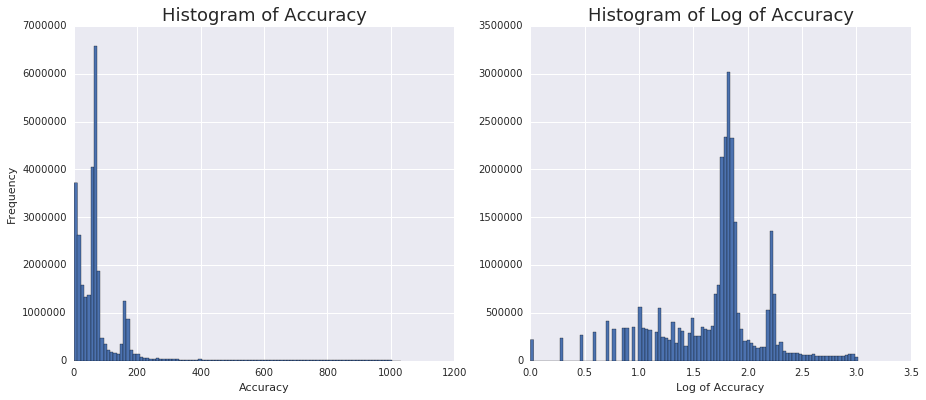

In [24]:
_, AX = plt.subplots(ncols=2, figsize=(15,6)) 
df_train.accuracy.hist(bins=100, ax=AX[0])
AX[0].set_title('Histogram of Accuracy', fontsize=18)
AX[0].set_xlabel('Accuracy')
AX[0].set_ylabel('Frequency')

np.log10(df_train.accuracy).hist(bins=100, ax=AX[1])
AX[1].set_title('Histogram of Log of Accuracy', fontsize=18)
AX[1].set_xlabel('Log of Accuracy')

print "CV of accuracy: {:.3f}".format(np.std(df_train.accuracy) / np.mean(df_train.accuracy))
print "CV of log of accuracy: {:.3f}".format(np.std(np.log10(df_train.accuracy)) / np.mean(np.log10(df_train.accuracy)))

* Following are the CV of accuracy at top 3 popular places, we can see that all places have lower CV of log of accuracy than CV of accuracy.
* During the section of Methodology, we can see that we can get better result if taking the log of accuray as our feature instead of accuracy. The reason behind it may be log of accuracy at each place has less level of disperion, so it means that the possibility overlapping would be lower.

In [25]:
for i, order in zip(range(3), ['1st', '2nd', '3rd']):
    place = place_ranking.index[i]
    data = df_train[df_train.place_id==place]
    print "The {} place:".format(order)
    print "CV of accuracy: {:.3f}".format(np.std(data.accuracy) / np.mean(data.accuracy))
    print "CV of log of accuracy: {:.3f}".format(np.std(np.log10(data.accuracy)) / np.mean(np.log10(data.accuracy)))
    print "-"*20

The 1st place:
CV of accuracy: 1.290
CV of log of accuracy: 0.210
--------------------
The 2nd place:
CV of accuracy: 1.294
CV of log of accuracy: 0.259
--------------------
The 3rd place:
CV of accuracy: 1.357
CV of log of accuracy: 0.238
--------------------


### Explore small grid
* From this section, it could be found that **adding dimension of time would help seperating clusters.**
* By zooming in on the maps, I'm trying to explore the data clusters on the x and y coordinates.
* It seems that there are some clusters could be found on the coordinates, but it still has quite overlaps.
* Inspired by [Alexandru Papiu](https://www.kaggle.com/apapiu/facebook-v-predicting-check-ins/random-forest-on-a-few-blocks/comments)

In [26]:
small_grid = df_train[(df_train.x<0.1)&(df_train.y<0.1)]
# Mapping each place id with one color
color = dict(zip(small_grid.place_id.unique(), cm.rainbow(np.linspace(0,1,small_grid.place_id.unique().shape[0]))))

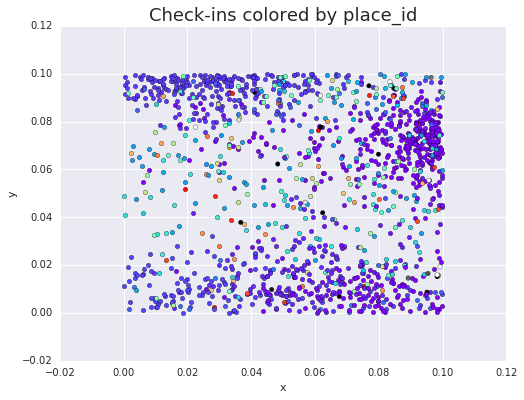

In [27]:
f, ax = plt.subplots()
for place, group in small_grid.groupby('place_id'):
    group.plot(ax=ax, kind='scatter', x='x', y='y', color=color[place])
ax.set_title('Check-ins colored by place_id', fontsize=18);

It could be found that the clusters are more easy to be seperated on some specific hour, because check-ins appear more often on specific hour for some specific places.

In [29]:
# Converted minutes into hours
small_grid.loc[:,'hour'] = ((small_grid.time /60)%24).astype(int)

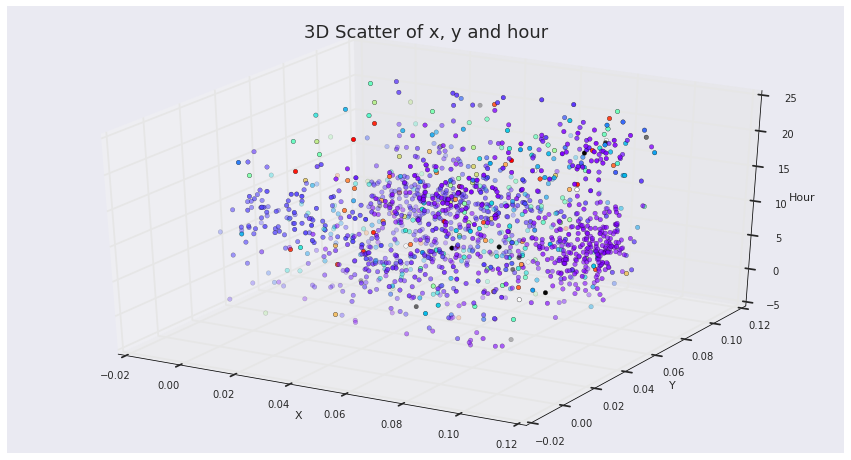

In [30]:
ax = plt.figure(figsize=(15,8)).gca(projection='3d')
for place, group in small_grid.groupby('place_id'):
    ax.scatter(group.x,group.y,group.hour,c=color[place])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Hour')
ax.set_title('3D Scatter of x, y and hour', fontsize=18);

From the below histogram, we could see the check-ins on these two places are almost complement on dimension of time, one is popular at morning and the other is popular at night. This could help us double check the idea of adding the dimensio of time.

In [31]:
print 'Top 3 popular places in the small grid'
for order, place in zip(['1st','2nd','3rd'], small_grid.place_id.value_counts().index[:3]):
    print '{} place: {}'.format(order, place)

Top 3 popular places in the small grid
1st place: 1006316884
2nd place: 5445221293
3rd place: 8378301865


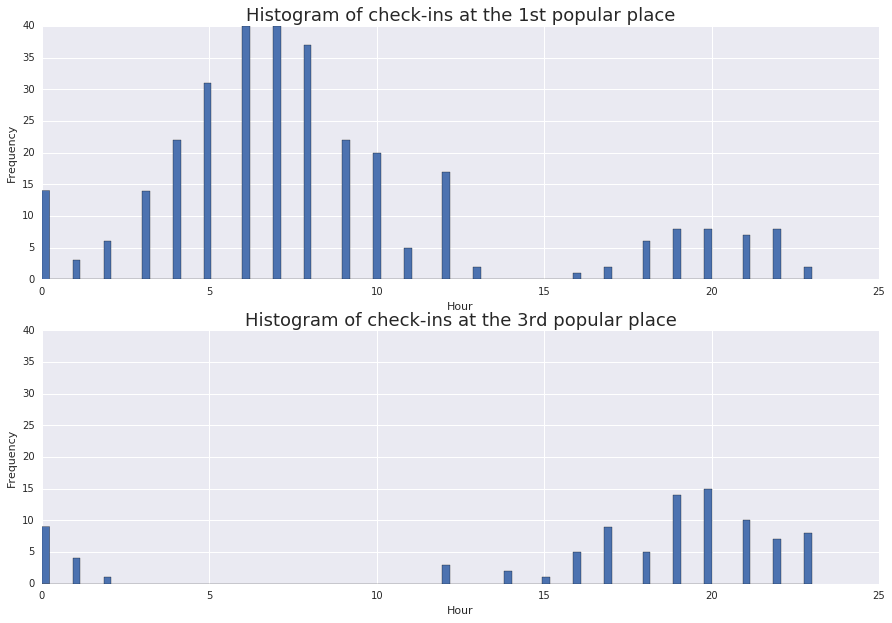

In [32]:
f, (ax1,ax2) = plt.subplots(nrows=2, sharey=True,figsize=(15,10))
small_grid[small_grid.place_id==1006316884].hour.hist(bins=100,ax=ax1)
ax1.set_title('Histogram of check-ins at the 1st popular place', fontsize=18)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Frequency')
small_grid[small_grid.place_id==8378301865].hour.hist(bins=100,ax=ax2)
ax2.set_title('Histogram of check-ins at the 3rd popular place', fontsize=18)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Frequency')
del small_grid

## Algorithms and Techniques

For this supervised classification problem, following are those algorithms I'm trying to use
* KNN (K-Nearest Neighbor)
    * Description:
        * When a prediction is required for a unseen data instance, the KNN algorithm will search through the training dataset for the k-most similar instances.
        * The similarity measure is dependent on the type of data. For real-valued data, the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) can be used. Other types of data such as categorical or binary data, [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) can be used.
        * It's a non parametric learning algorithm, so it means that KNN does not make any assumptions on the underlying data distribution.
        * It is also a lazy algorithm. What this means is that it does not use the training data points to do any generalization.
    * Discussion:
        * Since I do not have any assumptions about the data distribution, KNN could be the good start point.
        * The weight of y should be more than x because of the deviation of x is much more than y.
        * Since I only have limited knowledge about each feature but do not know exactly how important are they, the weight will be set based on trial and error.
        * Steps in Methodology:
            1. Dividing the whole map into many small cells.
            2. In each cell, splitting data by time into training and validation data sets.
            3. Training a KNN classifier in each cell without feature weighting, and calculating the accuracy.
            4. Training with feature weighting. The order of weights is y > x > year > hour > weekday > month > day. 
    * Reference:
        * [Tutorial To Implement k-Nearest Neighbors in Python From Scratch](http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)
        * [A Detailed Introduction to KNN](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/)
        * [K-Nearest Neighbors: dangerously simple](https://mathbabe.org/2013/04/04/k-nearest-neighbors-dangerously-simple/)

* Gaussian Naive Bayes
    * Description:
        * It's a simple classifier based on applying [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) with independence assumptions between features and probability models of each feature are Gaussian.
        * Equation of Bayes Theorem
            $$P(y|X) = \frac{P(X|y)P(y)}{P(X)}$$
            * X: features, y: class
            * P(y|X): posterior probability
            * P(y): prior probability of class
            * P(X): prior probability of features
            * P(X|y): class conditional model, which is gaussian distribution
    * Discussion:
        * From the below histograms, we could see that all the shape look like a bell. So I think it's worth trying to know how well this method could achieve.
        * And I assume each feature is independent although I do not prove it yet.
        * Steps in Methodology:
            1. Dividing the whole map into many small cells.
            2. In each cell, splitting data by time into training and validation data sets.
            3. Training a GNB classifier in each cell with feature selection, and calculating the accuracy.
            4. Training with feature selection. Selected features are x, y, hour, weekday, log of accuracy.
    * Reference:
        * [Wiki](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
        * [Intro of GNB](http://www.inf.ed.ac.uk/teaching/courses/iaml/slides/naive-2x2.pdf)
        * [A simple explanation of Naive Bayes Classification](http://stackoverflow.com/questions/10059594/a-simple-explanation-of-naive-bayes-classification)

* Kernel Density Estimation
    * Description:
        * Kernel density estimation is a data smoothing way to estimate the probability density function of a random variable.
        * <img src="http://scikit-learn.org/stable/_images/plot_kde_1d_001.png" alt="KDE on sklearn" style="width: 500px;"/> 
        * A major problem with histogram(upper-left panel) is that the choice of binning can have a disproportionate effect on the resulting visualization(upper-right panel). We can solve this problem and recover a smoother distribution by using KDE. By using different kernels, the visualization will be different. Bottom-left panel is top-hat kernel and bottom-right panel is Gaussian kernel.
        * The bandwidth of the kernel is a free parameter which exhibits a strong influences on the resulting estimate.
    * Discussion:
        * This problem could be approximately modeled as following 
            $$
                P(place\_id\ |\ x,\ y,\ time,\ accuracy) \\
                \approx P(x,\ y,\ time,\ accuracy|place\_id)*P(place\_id) \\
                \approx P(x|place\_id)*P(y|place\_id)*P(time|place\_id)*P(accuracy|place\_id)*P(place\_id)
            $$
        * Based on the result of GNB, the assumption that all conditional probabilities of features were independent could hold on this problem.
        * Steps in Methodology:
            1. Dividing the whole map into many small cells.
            2. In each cell, splitting data by time into training and validation data sets.
            3. In each cell, using kde to approximate the conditional probabilities of features.
            4. In each cell, calculating the probability of place_id
            5. Multiplying all the probabilities, sorting in descending order and picking the top 3 place ids.
    * Reference:
        * [Wiki](https://en.wikipedia.org/wiki/Kernel_density_estimation)
        * [KDE on sklearn](http://scikit-learn.org/stable/modules/density.html)

* Ensemble
    * Discussion
        * Based on following equation, finding the place_ids such that P(place_id) are top 3 value.
          $$
            P(place\_id)\ =\ \sum_{M}\sum_{i=0}^{k}\frac{W(M)}{i+1}
          $$
            * M: ensembled model
            * W(M): weight of model
            * i: the order of each row
            * k: the number of place_ids of each row
    * Reference
        * [Larry Freeman](https://github.com/larry94555/kaggle-Facebook-V)

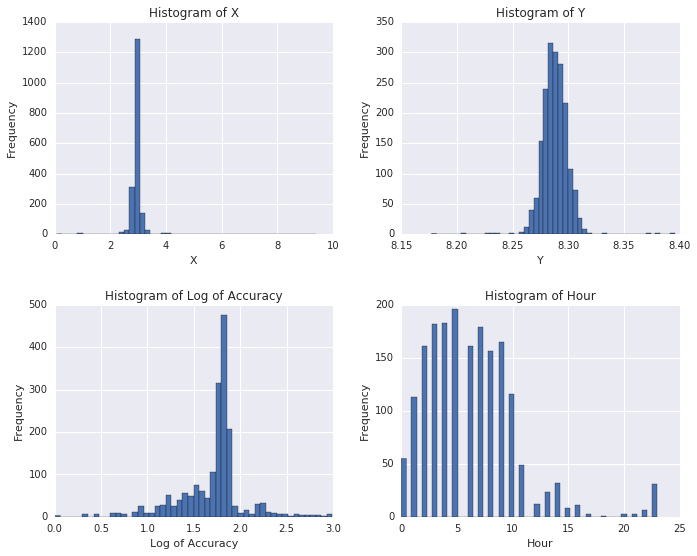

In [33]:
data = df_train[df_train.place_id == place_ranking.index[0]]
f, AX = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
# Histogram of X
data.x.plot(kind='hist',bins=50,ax=AX[0][0])
AX[0][0].set_xlabel('X')
AX[0][0].set_title('Histogram of X')
# Histogram of Y
data.y.plot(kind='hist',bins=50,ax=AX[0][1])
AX[0][1].set_xlabel('Y')
AX[0][1].set_title('Histogram of Y')
# Histogram of Log of Accuracy
np.log10(data.accuracy).plot(kind='hist',bins=50,ax=AX[1][0])
AX[1][0].set_xlabel('Log of Accuracy')
AX[1][0].set_title('Histogram of Log of Accuracy')
# Histogram of Hour
((data.time/60) % 24).astype(int).plot(kind='hist',bins=50,ax=AX[1][1])
AX[1][1].set_xlabel('Hour')
AX[1][1].set_title('Histogram of Hour')

plt.tight_layout(h_pad=1.5)
del data

## Benchmark

I use the most voted and forked methods on Kaggle forums as my benchmark.
* [KNN by Sandro](https://www.kaggle.com/svpons/facebook-v-predicting-check-ins/grid-knn/output)
    * Leader Board Score : 0.56736
    * Features this method used: [x, y, hour, weekday, day, month, year]
    * Corresponding weights: [500, 1000, 4, 3, 1./22, 2, 10]
    * This method divided the whole map into 20*40 grid cells for computational issues.
    * In each cell, it do not consider those place-ids if the number of occurrences is less than 5.

# Methodology

## Data Preprocessing

* Since it has been found that the unit of time is minute, we could add more fields related with time, which are **hour, weekday, month, year**.
* The initial date is randomly setted, so there will be a shift if it's wrong.
* The difference between hour and Hour is if dividing the interval by minutes.
* The difference between weekday and Weekday is if dividing the interval by hours.
* The difference between year and Year is if dividing the interval by months.

In [34]:
def add_time(df):
    # Set the initial date
    initial_date = np.datetime64('2014-01-01T01:01', dtype='datetime64[m]')
    # Training data
    time = pd.DatetimeIndex(df['time'] + initial_date)
    df['minute'] = time.minute
    # Dividing the interval between hours by minutes
    df['hour'] = time.hour + time.minute / 60.0
    df['hour_sin'] = np.sin(2*np.pi*df.hour/24)
    df['hour_cos'] = np.cos(2*np.pi*df.hour/24)
    # Dividing the interval between weekday by hours
    df['weekday'] = time.weekday + time.hour / 24.0
    df['weekday_sin'] = np.sin(2*np.pi*df.weekday/7)
    df['weekday_cos'] = np.cos(2*np.pi*df.weekday/7)
    df['day'] = time.dayofyear
    df['month'] = time.month - 1
    df['month_sin'] = np.sin(2*np.pi*(df.month-1)/7)
    df['month_cos'] = np.cos(2*np.pi*(df.month-1)/7)
    # Dividing the interval between year by months
    df['year'] = time.year - 2013 + time.month / 12.0   
    return df

df_train = add_time(df_train)

* Dividing the whole map into small grid cells and labeling the number on each cell, which is **grid_cell**.
* The variable of eps is used to be offset in otder to create a range of pos_x in [0, n_cell_x] amd a range of pos_y in [0, n_cell_y]

In [35]:
def add_grid_cell(df, n_cell_x, n_cell_y):
    eps = 0.00001
    size_x = 10.0 / n_cell_x
    size_y = 10.0 / n_cell_y

    pos_x = (np.where(df['x'].values < eps, 0, df['x'].values - eps) / size_x).astype(int)
    pos_y = (np.where(df['y'].values < eps, 0, df['y'].values - eps) / size_y).astype(int)
    df['grid_cell'] = pos_y * n_cell_x + pos_x
    return df

# Adding grid id
n_cell_x = 30 # The number of cells on axis-x.
n_cell_y = 90 # The number of cells on axis-y.
x_offset = 0.3 # The portion of augmation along axis-x.
y_offset = 0.1 # The portion of augmation along axis-y.
n_cells = n_cell_x * n_cell_y # Total number of cells
df_train = add_grid_cell(df_train, n_cell_x, n_cell_y)

* Converting accuracy into log scale

In [36]:
def log_acc(df):
    df['accuracy'] = pd.Series(np.log10(df.accuracy.values), index=df.index)
    return df

df_train = log_acc(df_train)

## Implementation

Because it will take too much time generating one submission file for validating improvement, I will instead using accuracy as metric for simplicity.

In [37]:
def calculate_accuracy(y_preds, y_tests):
    result = [] # The list of number of correctly preded labels in each cell
    total = 0 # The number of total preditions
    for y_pred, y_test in zip(y_preds, y_tests):
        result.append(np.sum(y_pred == y_test))
        total += y_test.shape[0]
    return  np.sum(result) * 100.0 / total

* Training and validation data are splited by the time and drop places if the number of occurances is less than threshold.
* Given the id of cell, training data will be selected from the cell with small border augmentation.
* Parameters:
    * df: dataframe of training data
    * cell_id: the id of selected cell
    * time: for splitting training and testing data
    * th: threshold of number of occurances
    * x_offset: the ratio of length of cell for border augmentation along x-axis
    * y_offset: the ratio of length of cell for border augmentation along y-axis

In [38]:
# Given cell_id, this function will split the data into training and testing in the specific cell.
def data_split(df, cell_id, x_offset, y_offset):
    # Select the specific cell with cell_id 
    df_train_cell = df.loc[df.grid_cell == cell_id]
    
    # set the splitting time to be 0.75 percentiles.
    time = df_train_cell.time.quantile(0.75)
    
    # Split training and testing data by time.
    X_valid = df_train_cell[df_train_cell.time > time]
    
    # extending the area of picked cell by using 3 more cells along y-axis and 2 more cells along x-axis
    x_offset *= 1.0/n_cell_x
    y_offset *= 1.0/n_cell_y
    x_min = df_train_cell.x.min()
    x_max = df_train_cell.x.max()
    y_min = df_train_cell.y.min()
    y_max = df_train_cell.y.max()
    X_train = df.loc[(df.x > x_min-x_offset)&(df.x < x_max+x_offset)&
                     (df.y > y_min-y_offset)&(df.y < y_max+y_offset)&
                     (df.time < time)]
    
    # Select the place ids in the cell if the number of place id is higher than the threshold    
    place_counts = X_train.place_id.value_counts()
    th = place_counts.quantile(0.1)
    mask = (place_counts[X_train.place_id] >= th).values
    X_train = X_train.loc[mask]
    
    y_train = X_train.place_id    
    y_valid = X_valid.place_id
    
    X_train = X_train.drop(['row_id', 'place_id'], axis=1)
    X_valid = X_valid.drop(['row_id', 'place_id'], axis=1)
    
    return X_train, X_valid, y_train, y_valid

In [39]:
def time_decay(t, time_end):
    alpha = 50
    return np.sum(np.exp(alpha * (t.values - time_end) / time_end))

In [40]:
def build_pr_place_table(df, x_offset, y_offset):
    pr_place_table = pd.DataFrame(index=df.place_id.unique())
    dpath = './pr_place_table_valid'
    if not os.path.isdir(dpath):
        os.makedirs(dpath)
    for cell_id in tnrange(n_cell_x*n_cell_y):
        fname = dpath + "/{}.csv".format(cell_id/100)
        if not os.path.isfile(fname):
            X_train, X_test, y_train, y_test = data_split(df, cell_id, x_offset, y_offset)
            X_train["place_id"] = y_train

            # Calculating the probability of each place
            time_end = X_train.time.max()
            groups = X_train.groupby('place_id')
            pr_place = groups.time.apply(time_decay, time_end=time_end)
            pr_place = pr_place / X_train.shape[0]
            pr_place = pr_place.apply(lambda p: p**0.15)
            pr_place_table[cell_id] = pr_place
            # Grouped 100 cells into one dataframe
            if cell_id % 100 == 99:
                pr_place_table.fillna(0, inplace=True)
                pr_place_table.to_csv(fname)
                pr_place_table = pd.DataFrame(index=df.place_id.unique())
    print "Successfully creat table!"

build_pr_place_table(df_train, x_offset, y_offset)


Successfully creat table!


* Parameters:
    * df: dataframe of training data
    * fw: dictionary of feature weights

In [41]:
# Given dataframe, this funciton will return the weighted result with following features.
def feature_engineering_KNN(df, fw):
    DF = df.copy()
    for col in fw:
        DF[col] = DF[col]*fw[col]
    return DF

### KNN
* I divide the whole map into 30*90 small cells and train each cell with one KNN classifier with droping any features as well as without feature weighting.
* I randomly select 40 cells for calculating the accuracy of predictions in order to know how good the classifier would be.
* This result is pretty bad if we just put every features into KNN.

In [42]:
# Randomly selected cells for training
n_validate_cells = 40 # Number of cells for validating
cell_ids = np.random.choice(n_cells, n_validate_cells)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

# Given cell_id, this function will train a KNN classifier on that cell and it returns the predicted as well as test labels. 
# Deuring training, it would not consider those place if the number of occurances is lower than the threshold.
def process_one_cell_KNN(df_train, cell_id, x_offset, y_offset, 
                         cols=None, fw=None, params={}):
    # Split data by time
    X_train, X_valid, y_train, y_valid = data_split(df_train, cell_id, x_offset, y_offset)
    
    # Feature Engineering
    if fw:
        X_train = feature_engineering_KNN(X_train, fw)
        X_valid = feature_engineering_KNN(X_valid, fw)

    # Converting into np array
    if cols:
        X_train = X_train[cols].values
        X_valid = X_valid[cols].values
    else:
        X_train = X_train.values
        X_valid = X_valid.values
    y_train = y_train.values
    y_valid = y_valid.values  

    # Creating KNN classifier
    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train)
    y_prob = pd.DataFrame(clf.predict_proba(X_valid), columns=clf.classes_)
    y_pred3 = [] # Predict top 3 place_ids
    y_pred1 = [] # Predict top 1 place_ids
    for _, row in y_prob.iterrows():
        data = row.sort_values(ascending=False).index[:3]
        y_pred3.append(data)
        y_pred1.append(data[:1])

    return y_pred3, np.array(y_pred1).reshape(1,-1)[0], y_valid

In [44]:
y_preds = []
y_valids = []
# Randomly select cells for validating
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    _, y_pred, y_valid = process_one_cell_KNN(df_train, cell_id, x_offset, y_offset)
    y_preds.append(y_pred)
    y_valids.append(y_valid)
print "Accuracy of KNN in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of KNN in 40 cells: 4.0660


### GNB
* Same as KNN, I train a GNB on each cell with all the features.
* The result is slightly better than KNN but it still needs a lot of improvement.

In [45]:
from sklearn.naive_bayes import GaussianNB

# Given cell_id, this function will train a GNB classifier on that cell and it returns the predicted as well as test labels. 
# Deuring training, it would not consider those place if the number of occurances is lower than the threshold.
def process_one_cell_GNB(df_train, cell_id, x_offset, y_offset, cols=None):
    # Split data by time
    X_train, X_valid, y_train, y_valid = data_split(df_train, cell_id, x_offset, y_offset)
    
    # Converting into np array
    if cols:
        X_train = X_train[cols].values
        X_valid = X_valid[cols].values
    else:
        X_train = X_train.values
        X_valid = X_valid.values
    
    y_train = y_train.values
    y_valid = y_valid.values
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return y_pred, y_valid

In [46]:
y_preds = []
y_valids = []
# Randomly select cells for validating
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    y_pred, y_valid = process_one_cell_GNB(df_train, cell_id, x_offset, y_offset)
    y_preds.append(y_pred)
    y_valids.append(y_valid)
print "Accuracy of GNB in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of GNB in 40 cells: 9.2475


## Refinement

### KNN
* Refinement #1: Selecting some features and using weights.
* We could see the accuracy is boosted from 4.x to 43.x

In [47]:
y_preds = []
y_valids = []
# Weight of features
fw = {'x':600, 'y':1200, 'hour':10, 'weekday':10, 'day':0.01, 'accuracy': 30, 'month':2, 'year': 15}
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    _, y_pred, y_valid = process_one_cell_KNN(df_train, cell_id, x_offset, y_offset, cols=fw.keys(), fw=fw)
    y_preds.append(y_pred)
    y_valids.append(y_valid)
print "Accuracy of KNN in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of KNN in 40 cells: 43.2289


* Refinement #2: Choosing different parameters for KNN.
* We could see the accuracy is boosted from 43.x to 45.x

In [48]:
y_preds = []
y_valids = []
fw = {'x':600, 'y':1200, 'hour':10, 'weekday':10, 'day':0.01, 'accuracy': 30, 'month':2, 'year': 15}
params = {'n_neighbors':25, 'weights':'distance', 'metric':'manhattan'}
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    _, y_pred, y_valid = process_one_cell_KNN(df_train, cell_id, x_offset, y_offset, 
                                          cols=fw.keys(), fw=fw, params=params)
    y_preds.append(y_pred)
    y_valids.append(y_valid)
print "Accuracy of KNN in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of KNN in 40 cells: 45.6568


* Refinement #3: Transforming scales of hour, weekday, and month into sin and cos for solving problems of periods.
* We could see the accuracy is boosted from 45.x to 46.x

In [49]:
KNN_preds = []
y_preds = []
y_valids = []
fw = {'x':600, 'y':1200, 'hour_sin':15, 'hour_cos':15, 'weekday_sin':10, 'weekday_cos':10, 
      'month_sin':2, 'month_cos':2, 'day':0.01, 'accuracy': 30, 'year': 15}
params = {'n_neighbors':25, 'weights':'distance', 'metric':'manhattan'}
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    y_pred3, y_pred1, y_valid = process_one_cell_KNN(df_train, cell_id, x_offset, y_offset, 
                                          cols=fw.keys(), fw=fw, params=params)
    KNN_preds.append(y_pred3)
    y_preds.append(y_pred1)
    y_valids.append(y_valid)
print "Accuracy of KNN in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of KNN in 40 cells: 46.6895


### GNB

* Refinement #1: Selecting some features.
* We could see the accuracy is boosted from 9.x to 42.x

In [50]:
GNB_preds = []
y_valids = []
# Features considered in GNB model
gnb_cols = ['x', 'y', 'hour_sin', 'hour_cos', 'weekday', 'accuracy']
# Randomly select cells for validating
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    y_pred, y_valid = process_one_cell_GNB(df_train, cell_id, x_offset, y_offset, cols=gnb_cols)
    GNB_preds.append(y_pred)
    y_valids.append(y_valid)
print "Accuracy of GNB in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(GNB_preds, y_valids))


Accuracy of GNB in 40 cells: 42.3910


* Refinement #2: Adding probability of place.
    $$
          P(place\_id\ |\ x,\ y,\ time,\ accuracy) \\
          \approx P(x|place\_id)*P(y|place\_id)*P(time|place\_id)*P(accuracy|place\_id)*P(place\_id)
    $$
* We could see the accuracy is boosted from 42.x to 43.x

In [51]:
def process_one_cell_GNB(df_train, cell_id, x_offset, y_offset, cols=None):
    # Split data by time
    X_train, X_valid, y_train, y_valid = data_split(df_train, cell_id, x_offset, y_offset)
    
    X_train["place_id"] = y_train
    # Calculating the probability of each place in cell
    place_prob = X_train.place_id.value_counts() / X_train.shape[0]
    place_prob = place_prob.apply(lambda p: p**0.3)

    # Converting into np array
    if cols:
        X_train = X_train[cols].values
        X_valid = X_valid[cols].values
    else:
        X_train = X_train.values
        X_valid = X_valid.values
    
    y_train = y_train.values
    y_valid = y_valid.values
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    # Calculating the final probabilities of each row
    y_prob = pd.DataFrame(clf.predict_proba(X_valid), columns=clf.classes_)
    y_prob = y_prob.apply(lambda c: place_prob[c.index]*c.values, axis=1)
    
    # Sorting the final probabilities of each row
    y_pred = []
    for _, row in y_prob.iterrows():
        y_pred.append(row.sort_values(ascending=False).index[:1])
    
    return np.array(y_pred).reshape(1,-1)[0], y_valid

In [52]:
GNB_preds = []
y_valids = []
# Features considered in GNB model
gnb_cols = ['x', 'y', 'hour_sin', 'hour_cos', 'weekday', 'accuracy']
# Randomly select cells for validating
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    y_pred, y_valid = process_one_cell_GNB(df_train, cell_id, x_offset, y_offset, cols=gnb_cols)
    GNB_preds.append(y_pred)
    y_valids.append(y_valid)
print "Accuracy of GNB in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(GNB_preds, y_valids))


Accuracy of GNB in 40 cells: 43.0858


* Refinement #3: When calculating probabilities of place, more recent check-in should give higher weight. I use exponential function to model weights.
    $$
          P(place\_id) = \frac{1}{|U|}\ \sum_i e^{\alpha \ \frac{(t_i\ -\ t_{end})}{t_{end}}}
    $$
    * t<sub>i</sub>: time of check-in given place_id
    * t<sub>end</sub>: the last time of check-in in the cell
    * |U|: the number of total check-ins in the cell
    * alpha: the constant for adjusting decay
* We could see the accuracy is boosted from 43.0x to 43.3x

In [53]:
def process_one_cell_GNB(df_train, cell_id, x_offset, y_offset, cols=None):
    # Split data by time
    X_train, X_valid, y_train, y_valid = data_split(df_train, cell_id, x_offset, y_offset)
    
    pr_place_table = pd.read_csv('./pr_place_table_valid/{}.csv'.format(cell_id/100), index_col=0)

    # Converting into np array
    if cols:
        X_train = X_train[cols].values
        X_valid = X_valid[cols].values
    else:
        X_train = X_train.values
        X_valid = X_valid.values
    
    y_train = y_train.values
    y_valid = y_valid.values
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    # Calculating the final probabilities of each row
    y_prob = pd.DataFrame(clf.predict_proba(X_valid), columns=clf.classes_)
    y_prob = y_prob.apply(lambda c: pr_place_table[str(cell_id)][c.index]*c.values, axis=1)
    
    # Sorting the final probabilities of each row
    y_pred3 = [] # Predict top 3 place_ids
    y_pred1 = [] # Predict top 1 place_ids
    for _, row in y_prob.iterrows():
        data = row.sort_values(ascending=False).index[:3]
        y_pred3.append(data)
        y_pred1.append(data[:1])
    
    return y_pred3, np.array(y_pred1).reshape(1,-1)[0], y_valid

In [54]:
GNB_preds = []
y_preds = []
y_valids = []
# Features considered in GNB model
gnb_cols = ['x', 'y', 'hour_sin', 'hour_cos', 'weekday', 'accuracy']
# Randomly select cells for validating
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    y_pred3, y_pred1, y_valid = process_one_cell_GNB(df_train, cell_id, x_offset, y_offset, cols=gnb_cols)
    GNB_preds.append(y_pred3)
    y_preds.append(y_pred1)
    y_valids.append(y_valid)
print "Accuracy of GNB in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of GNB in 40 cells: 43.3974


### KDE
* Refinement: Based on the assumption of independent features, using KDE to get better estimation of probabilities of features.
* We could see the accuracy is boosted from 43.x to 46.x

* For setting bandwidth of kernel, I use [Scott's Rule](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.gaussian_kde.html#r318) with slight modification.

In [55]:
def scott_rule(group, col):
    # Scott's Rule : n**(-1./(d+4)), n: number of data, d: number of dimension
    if math.isnan(group[col].std()):
        bw = group.shape[0] ** (-0.3)
    else:
        bw = (group.shape[0] ** (-0.3)) * (group[col].std()+0.01)
    return bw

* In each cell, creating a table of kde of related features
* Parameters:
    * cols: the list of name of features
    * place_ids: the series of unique place ids in the cell

In [56]:
from sklearn.neighbors import KernelDensity
def build_KDE(X_train, X_valid, cols, place_ids, cell_id, path):
    kde_table = {}
    dpath = path + '/{}'.format(cell_id)
    groups = X_train.groupby('place_id')
    for col in cols:
        fpath = path + '/{}/{}.csv'.format(cell_id, col)
        if not os.path.isfile(fpath):
            samples = X_valid[col].unique()
            df = pd.DataFrame(index=place_ids, columns=['{:.5f}'.format(v) for v in samples])
            bw = groups.apply(scott_rule, col=col)
            for place, group in groups:
                # Creating KDE
                kde = KernelDensity(kernel='gaussian', bandwidth=bw[place])
                kde.fit(group[col][:, np.newaxis])
                # Storing KDE for each place
                df.loc[place] = np.exp(kde.score_samples(samples[:,np.newaxis]))
            if not os.path.isdir(dpath):
                os.makedirs(dpath)
            df.to_csv(fpath)
        kde_table[col] = pd.read_csv(fpath, index_col=0)
    return kde_table

In [57]:
def process_one_cell_KDE(df_train, cell_id, cols, x_offset, y_offset):
    X_train, X_valid, y_train, y_valid = data_split(df_train, cell_id, x_offset, y_offset)
    X_train['place_id'] = y_train
    
    # Unique place ids in the cell
    place_ids = X_train.place_id.unique()
    # Building KDE of columns, kde_cols, for each place_id
    kde_table = {}
    groups = X_train.groupby('place_id')
    for col in cols:
        table = {}
        bw = groups.apply(scott_rule, col=col)
        for place, group in groups:
            kde = KernelDensity(kernel='gaussian', bandwidth=bw[place])
            kde.fit(group[col][:, np.newaxis])
            table[place] = kde
        kde_table[col] = table
    
    # Calculating the probability of each place
    pr_place_table = pd.read_csv('./pr_place_table_valid/{}.csv'.format(cell_id/100), index_col=0)
    
    # Predicting
    prob = pd.DataFrame(np.ones((place_ids.shape[0], X_valid.shape[0])), columns=X_valid.index, index=place_ids)
    for col in cols:
        samples = X_valid[col].values[:,np.newaxis]
        for place in prob.index:
            kde = kde_table[col][place]
            temp = np.exp(kde.score_samples(samples))
            prob.loc[place] = prob.loc[place].values * temp
            
    probs = prob.apply(lambda p: (p.values ** 0.2) * pr_place_table[str(cell_id)][p.index])
    probs = probs.transpose()
    
    y_pred = []
    for _, row in probs.iterrows():
        y_pred.append(row.sort_values(ascending=False).index[:3])
    
    return y_pred, probs.idxmax(1).values, y_valid

In [58]:
KDE_preds = []
y_preds = []
y_valids = []
# Features considered in KDE model
kde_cols = ['x', 'y', 'hour', 'weekday', 'accuracy']
for cell_id in tqdm_notebook(cell_ids, total=n_validate_cells):
    y_pred3, y_pred1, y_valid = process_one_cell_KDE(df_train, cell_id, kde_cols, x_offset, y_offset)
    KDE_preds.append(y_pred3)
    y_preds.append(y_pred1)
    y_valids.append(y_valid)
print "Accuracy of KDE in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(y_preds, y_valids))


Accuracy of KDE in 40 cells: 46.0974


### Ensemble
* The weights of each model are:
    * KDE: 68
    * KNN: 71
    * GNB: 19
* We could see the accuracy is boosted from 46.x to 47.x

In [59]:
from collections import Counter
weights = [68, 71, 19]
preds = [KDE_preds, KNN_preds, GNB_preds]

ensemble_preds = []
for cell in tnrange(n_validate_cells):
    result_cell = []
    for row in range(y_valids[cell].shape[0]):
        result_row = {}
        for i, model in enumerate(preds):
            weight = weights[i]
            for j, pred in enumerate(model[cell][row]):
                if pred in result_row:
                    curr = result_row[pred]
                else:
                    curr = 0
                curr += weight/(j+1.0)
                result_row[pred] = curr
        result_cell.append(Counter(result_row).most_common(1)[0][0])
    ensemble_preds.append(np.array(result_cell))
print "Accuracy of Ensemble in {} cells: {:.4f}".format(n_validate_cells, calculate_accuracy(ensemble_preds, y_valids))


Accuracy of Ensemble in 40 cells: 47.3316


# Results

## Model Evaluation and Validation
* In this section, I will generate submission files of each algorithms and report the scores of each model.
* The final model is using ensemble of all three models, KNN, GNB and KDE.
* The weights of each model are {KDE: 68, KNN: 71, GNB: 19}
* I run files on Google clound, machine type is 4 vCPUs, 15GB.

### Utility Functions

In [60]:
# This function will write the dataframe, df_aux, into a csv for submitting on Kaggle.
def generate_submission(df_aux, fname):
    print 'Generating submission file ...'
    ds_sub = df_aux['place1'].str.cat([df_aux['place2'], df_aux['place3']], sep=' ')
    ds_sub.name = 'place_id'
    ds_sub.to_csv(fname, index=True, header=True, index_label='row_id')

In [61]:
def select_cell(df, cell_id, x_offset, y_offset):
    # Select the specific cell with cell_id 
    df_train_cell = df.loc[df.grid_cell == cell_id]
    x_offset *= 1.0/n_cell_x
    y_offset *= 1.0/n_cell_y
    x_min = df_train_cell.x.min()
    x_max = df_train_cell.x.max()
    y_min = df_train_cell.y.min()
    y_max = df_train_cell.y.max()
    X_train = df.loc[(df.x > x_min-x_offset)&(df.x < x_max+x_offset)&
                     (df.y > y_min-y_offset)&(df.y < y_max+y_offset)]
    place_counts = X_train.place_id.value_counts()
    th = place_counts.quantile(0.1)
    mask = (place_counts[X_train.place_id] >= th).values
    X_train = X_train.loc[mask]
    return X_train

In [62]:
def build_pr_place_table_sub(place_ids):
    pr_place_table = pd.DataFrame(index=place_ids)
    dpath = './pr_place_table'
    if not os.path.isdir(dpath):
        os.makedirs(dpath)
    for cell_id in tnrange(n_cells):
        fname = dpath + "/{}.csv".format(cell_id/100)
        if not os.path.isfile(fname):
            X_train = pd.read_csv('./X_train/{}.csv'.format(cell_id), index_col=0)

            # Calculating the probability of each place
            time_end = X_train.time.max()
            groups = X_train.groupby('place_id')
            pr_place = groups.time.apply(time_decay, time_end=time_end)
            pr_place = pr_place / X_train.shape[0]
            pr_place = pr_place.apply(lambda p: p**0.15)
            pr_place_table[cell_id] = pr_place
            # Grouped 100 cells into one dataframe
            if cell_id % 100 == 99:
                pr_place_table.fillna(0, inplace=True)
                pr_place_table.to_csv(fname)
                pr_place_table = pd.DataFrame(index=df.place_id.unique())
    print "Successfully creat table!"

### KNN
* *Score on Kaggle Leaderboard: 0.57855*
* Run time: 1 hours
* Parameters of KNN:
    * n_neighbors: 25
    * weights: distance
    * metric: manhattan
    * Feature-Weight:
        * x-600, y-1200, hour_sin-15, hour_cons-15
        * weekday_sin-10, weekday_cos-10
        * month_sin-2, month_cos-2
        * day-0.01, accuracy-30, year-15

In [63]:
# Modified function, process_one_cell_KNN, in order to generate submission file.
def one_cell_KNN_sub(cell_id, fw, params):
    # Select the specific cell with cell_id for testing
    X_test = pd.read_csv('./X_test/{}.csv'.format(cell_id), index_col=0)
    row_ids = X_test.index

    # Select the specific cell with cell_id for training
    X_train = pd.read_csv('./X_train/{}.csv'.format(cell_id), index_col=0)  

    # Feature Engineering
    X_train = feature_engineering_KNN(X_train, fw)
    X_test = feature_engineering_KNN(X_test, fw)

    # Mapping place ids into values between 0 and n_classes-1
    le = LabelEncoder()
    y_train = le.fit_transform(X_train.place_id.values)

    cols = fw.keys()
    X_train = X_train[cols].values
    X_test = X_test[cols].values

    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    # Reverse sorting and taking the top 3 place ids
    pred_labels = le.inverse_transform(np.argsort(y_pred, axis=1)[:,::-1][:,:3])
    return pred_labels, row_ids

In [64]:
def grid_KNN_sub(fw, params, n_cells, fname):
    if os.path.isfile(fname):
        print 'File has been generated!'
    else:
        preds = np.zeros((8607230, 3), dtype=int)
        for cell_id in tnrange(n_cells):
            pred_labels, row_ids = one_cell_KNN_sub(cell_id, fw, params)
            preds[row_ids] = pred_labels

        df_aux = pd.DataFrame(preds, dtype=str, columns=['place1', 'place2', 'place3'])
        generate_submission(df_aux, fname)

In [65]:
# Weight of features
fw = {'x':600, 'y':1200, 'hour_sin':15, 'hour_cos':15, 'weekday_sin':10, 'weekday_cos':10, 
      'month_sin':2, 'month_cos':2, 'day':0.01, 'accuracy': 30, 'year': 15}
params = {'n_neighbors':25, 'weights':'distance', 'metric':'manhattan'}
grid_KNN_sub(fw, params, n_cells, 'sub_KNN.csv')

File has been generated!


### Gaussian Naive Bayes
*Score on Kaggle Leaderboard: 0.54893*
* Run time: 6 hours
* Parameters of GNB:
    * Features:
        * x, y, hour_sin, hour_cos
        * minute, weekday, accuracy

In [66]:
build_pr_place_table_sub(df_train.place_id.unique())


Successfully creat table!


In [67]:
# Modifying function, process_one_cell_KNN, in order to generate submission file.
def one_cell_GNB_sub(cell_id, cols):
    # Select the specific cell with cell_id for training
    X_train = pd.read_csv('./X_train/{}.csv'.format(cell_id), index_col=0)
    
    # Select the specific cell with cell_id for testing
    X_test = pd.read_csv('./X_test/{}.csv'.format(cell_id), index_col=0)
    row_ids = X_test.index
    
    y_train = X_train.place_id.values
    X_train = X_train[cols].values
    X_test = X_test[cols].values
    
    # Probability of each place
    pr_place_table = pd.read_csv('./pr_place_table/{}.csv'.format(cell_id/100), index_col=0)
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = pd.DataFrame(clf.predict_proba(X_test), columns=clf.classes_)
    y_pred = y_pred.apply(lambda c: pr_place_table[str(cell_id)][c.index]*c.values, axis=1)
    # Reverse sorting and taking the top 3 place ids
    pred_labels = []
    for _, row in y_pred.iterrows():
        pred_labels.append(row.sort_values(ascending=False).index[:3])
        
    return pred_labels, row_ids

In [68]:
def grid_GNB_sub(cols, n_cells, fname):
    if os.path.isfile(fname):
        print 'File has been generated!'
    else:
        preds = np.zeros((8607230, 3), dtype=int)
        for cell_id in tnrange(num_cells):
            pred_labels, row_ids = one_cell_GNB_sub(cell_id, cols)
            preds[row_ids] = pred_labels

        df_aux = pd.DataFrame(preds, dtype=str, columns=['place1', 'place2', 'place3'])
        generate_submission(df_aux, fname)

In [69]:
# Features considered in GNB model
gnb_cols = ['x', 'y', 'hour_sin', 'hour_cos', 'minute', 'weekday', 'accuracy']
grid_GNB_sub(gnb_cols, n_cells, 'sub_GNB.csv')

File has been generated!


### Kernel Density Estimation
* *Score on Kaggle Leaderboard: 0.58171*
* Run time: 23 hours
* Parameters of KDE:
    * Features:
        * x, y, hour, weekday, accuracy
    * Setting bandwidth: $n^{-0.3} \times \sigma$
        * n: number of data
        * $\sigma$: standard deviation

In [70]:
# Modifying function, process_one_cell_KDE, in order to generate submission file.
def one_cell_KDE_sub(cell_id, cols):
    # Select the specific cell with cell_id for training
    X_train = pd.read_csv('./X_train/{}.csv'.format(cell_id), index_col=0)
    
    # Select the specific cell with cell_id for testing
    X_test = pd.read_csv('./X_test/{}.csv'.format(cell_id), index_col=0)
    row_ids = X_test.index
    
    # All place ids in the cell
    place_ids = X_train.place_id.unique()
    
    # Building KDE of columns, kde_cols, for each place_id
    kde_table = {}
    groups = X_train.groupby('place_id')
    for col in cols:
        table = {}
        bw = groups.apply(scott_rule, col=col)
        for place, group in groups:
            kde = KernelDensity(kernel='gaussian', bandwidth=bw[place])
            kde.fit(group[col][:, np.newaxis])
            table[place] = kde
        kde_table[col] = table
    
    # Probability of each place
    pr_place_table = pd.read_csv('./pr_place_table/{}.csv'.format(cell_id/100), index_col=0)

    # Predicting
    prob = pd.DataFrame(np.ones((place_ids.shape[0], X_test.shape[0])), columns=X_test.index, index=place_ids)
    for col in cols:
        samples = X_test[col].values[:,np.newaxis]
        for place in prob.index:
            kde = kde_table[col][place]
            temp = np.exp(kde.score_samples(samples))
            prob.loc[place] = prob.loc[place].values * temp
    probs = prob.apply(lambda p: (p.values ** 0.2) * pr_place_table[str(cell_id)][p.index])
    probs = probs.transpose() 
    
    # Sorting probabilities and choosing top 3 row by row
    pred_labels = []
    for _, row in probs.iterrows():
        pred_labels.append(row.sort_values(ascending=False).index[:3])
    
    return np.array(pred_labels), row_ids

In [71]:
def grid_KDE_sub(cols, num_cells, fname):
    if os.path.isfile(fname):
        print 'File has been generated!'
    else:
        preds = np.zeros((8607230, 3), dtype=int)
        for cell_id in tnrange(num_cells):
            pred_labels, row_ids = one_cell_KDE_sub(cell_id, cols)
            preds[row_ids] = pred_labels

        df_aux = pd.DataFrame(preds, dtype=str, columns=['place1', 'place2', 'place3'])
        generate_submission(df_aux, fname)

In [72]:
# Features considered in KDE model
kde_cols = ['x', 'y', 'hour', 'weekday', 'accuracy']
grid_KDE_sub(kde_cols, n_cells, 'sub_KDE.csv')

File has been generated!


### Ensemble
* *Score on Kaggle Leaderboard: 0.59250*
* Run time: 2.5 hours
* Parameters of Ensemble:
    * The weights of each model are:
        * KDE: 68
        * KNN: 71
        * GNB: 19

In [73]:
if not os.path.isfile('sub_ensemble.csv'):
    del df_train
    df_KDE = pd.read_csv('sub_KDE.csv')
    df_KNN = pd.read_csv('sub_KNN.csv')
    df_GNB = pd.read_csv('sub_GNB.csv')
    
    weights = [68, 71, 19]
    models = [df_KDE, df_KNN, df_GNB]

    df_ensemble = pd.DataFrame(columns=df_KDE.columns)
    df_ensemble.row_id = df_KDE.row_id

    for row in tnrange(8607230):
        place_ids = {}
        # Ensemble
        for i, model in enumerate(models):
            weight = weights[i]
            for j, place_id in enumerate(model.loc[row].place_id.split()):
                if place_id in place_ids:
                    place_ids[place_id] += weight/(j+1.0)
                else:
                    place_ids[place_id] = weight/(j+1.0)
        new_preds = ' '.join([x[0] for x in Counter(place_ids).most_common(3)])
        # Select top 3 place_id
        df_ensemble.set_value(row, 'place_id', new_preds)
    df_ensemble.to_csv('sub_ensemble.csv', index=False, header=True)
print "File has been generated!"

File has been generated!


## Justification
* In this section, I try to compare the score of mine on leardboard with benchmark.

| Model | Score | Ranking |
|:-:|:-:|:-:|
| Benchmark | 0.56736 | 585/1212 |
| My Ensemble Model | 0.59250 | 63/1212 |



* Frow above table, we can see that score of final solution is stronger than benchmark.
* The final solution is significant enough because the ranking has been improved to top 6%(63/1212).

# Conclusion

## Free-Form Visualization
The most important insight into this data is the relative popularity of places, P(place), varied substantially over time (really it should be written as P(place, time)), and it seemed hard to forecast it from the training data, as following figures show.
* Refrence
    * [Discussion Thread](https://www.kaggle.com/c/facebook-v-predicting-check-ins/forums/t/22078/solution-sharing/126235#post126235)
    * [Blog on Kaggle](http://blog.kaggle.com/2016/08/02/facebook-v-predicting-check-ins-winners-interview-2nd-place-markus-kliegl/)

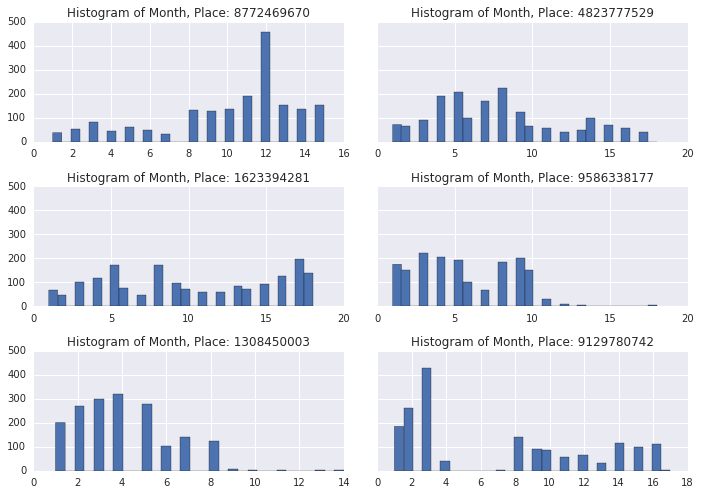

In [103]:
_, ax = plt.subplots(nrows=3, ncols=2, sharey=True,figsize=(10,7))
plt.tight_layout(h_pad=1.5)
for i, place_id in enumerate(place_ranking[:6].index):
    place = df_train[df_train.place_id == place_id]
    place.Month = 12*place.year - 12
    col = i/3
    row = i%3
    ax[row][col].set_title('Histogram of Month, Place: {}'.format(place_id))
    place.Month.hist(bins=30, ax=ax[row][col])

## Reflection
* Problem Definition:
    * Predicting the top 3 places a person would most likely to check in to.
    * The probability of place could be modeled as
        $$
            Pr(place\_id\ |\ x, y, time, acccuracy)
        $$
    * This problem is categorized as supervised classification.
* Training data:
    * x y: coordinates
    * accuracy: location accuracy 
    * time: timestamp
* Data exploration
    * Check-ins are roughly uniformly distributed on the map.
    * The unit of time is minute.
    * Majority of accuracy value is under 200.
    * Training and testing data are splitted by time.
* Algorithm:
    1. Dividing the map into 30X90 small cells.
    2. Converting time into minute, hour, month, year
    3. Comverting accuracy by log function
    4. Training three different models
    5. Selecting features and adjust parameters of model by trial and error.
        * KNN
            * n_neighbors: 25
            * weights: distance
            * metric: manhattan
            * Feature-Weight:
                * x-600, y-1200, hour_sin-15, hour_cons-15
                * weekday_sin-10, weekday_cos-10
                * month_sin-2, month_cos-2
                * day-0.01, accuracy-30, year-15
        * GNB
            * Features:
                * x, y, hour_sin, hour_cos
                * minute, weekday, accuracy
        * KDE
            * Features:
                * x, y, hour, weekday, accuracy
                * Setting bandwidth: $n^{-0.3} \times \sigma$
                    * n: number of data
                    * $\sigma$: standard deviation
        * Ensemble
            * Model-Weight:
                * KDE-68
                * KNN-71
                * GNB-19

## Improvement
Based on shared methods on the forum of Kaggle, there are two aspects of ideas could help improving result:
#### Learning the conditional distributions more efficient and accurate
* As [Jack mentioned](https://www.kaggle.com/rsakata/facebook-v-predicting-check-ins/3rd-place-solution-simple-version/comments#126585), estimation of histograms should consider effects of time because they are varing ocer time.
* Closer samples has to be weighted more, taking distribution of x as an example:
    $count(x) = count(x) + 0.8*(count(x-1)+count(x+1)) + 0.6*(count(x-2)+count(x+2))$  
* Reference:
    * [Script by Jack](https://www.kaggle.com/rsakata/facebook-v-predicting-check-ins/3rd-place-solution-simple-version/comments)
    
#### Learning from the future
* As [Markus mentioned](https://www.kaggle.com/c/facebook-v-predicting-check-ins/forums/t/22078/solution-sharing/126235#post126235), using just P(place_id) based on the train data, the predictions were already very good: About half of the time the first prediction was correct. So we could think of the top predictions as actually labeling the test data - just very noisily - and train on the test data using the top 10-20 or so predicted place_id's as labels with their probabilities as weights.
* This idea led to an approach of iterating between making predictions for the test data and learning from those predictions.
* Reference:
    * [Script by Markus](https://github.com/mkliegl/kaggle-Facebook-V)